**This notebook implements a one-dimensional GAN which generates the output of a cubic function**

The function below generates n samples of the cubic function, the domain of the function is chosen to be n random integers in the range -0.5 to 0.5. The function returns a two dimensional vector(inputs in the first column and outputs in the second) and a one dimensional vector of class labels( in this case, 1)

In [1]:
import numpy as np
def generate_real_samples(n):
    '''generate n real samples with class labels'''
    x1 = np.random.rand(n) - 0.5 #generate a random number between [-0.5,0.5]
    x2 = x1**3        #generate outputs
    x1 = x1.reshape(n, 1)
    x2 = x2.reshape(n, 1)
    X = np.hstack((x1, x2))   #stack layers
    y = np.ones((n, 1))     #generate class label
    return X,y

The function below defines the discriminator model, it is one of the two components of a GAN. It's job is to classify whether the numbers generated by the generator model are real or fake( ie: if they are the output to our function or not). 

Using TensorFlow backend.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 25)                75        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 25)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)                390       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 15)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 80        
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 5)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6

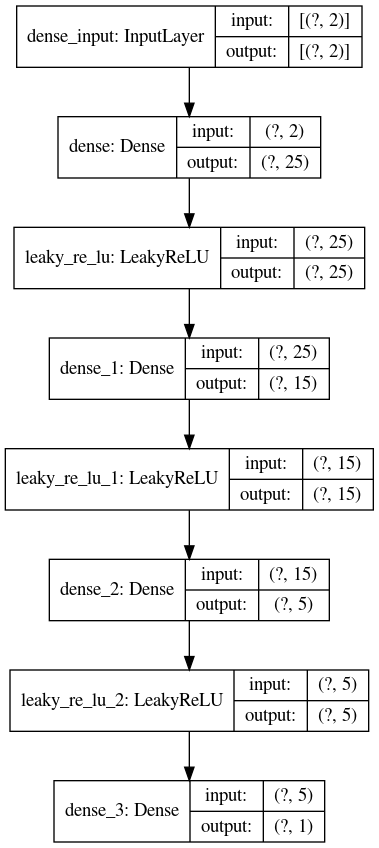

In [2]:
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU
from keras.utils import plot_model
import matplotlib.pyplot as plt

def define_discriminator(inputs = 2):
    ''' function to return the compiled discriminator model'''
    model = Sequential()
    model.add(Dense(25, activation = 'relu', kernel_initializer = 'he_uniform', input_dim = inputs))
    model.add(LeakyReLU(alpha = 0.01))
    model.add(Dense(15, activation = 'relu', kernel_initializer = 'he_uniform'))
    model.add(LeakyReLU(alpha = 0.01))
    model.add(Dense(5, activation = 'relu', kernel_initializer = 'he_uniform'))
    model.add(LeakyReLU(alpha = 0.01))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

discriminator_model = define_discriminator()
discriminator_model.summary()
plot_model(discriminator_model, to_file = 'discriminator_model.png', show_shapes = True, show_layer_names = True)

The function below makes up the second component of a GAN. It takes an input point from a latent space and generate a vector with two dimensions(like the X vector returned by the generate_real_samples function)
<br>
A latent variable is a hidden variable, and the space it belongs to is called the latent space. We can arbitrarily assign a size to our latent space(here it is 5). The points in the latent space are meaningless until the generator model begins learning and starts assigning meaning to the points in the space. After training, the points in the latent space correspond to the generated samples.

Note that the generator model isn't compiled here, it's because it is fit indirectly.

In [3]:
def define_generator(latent_dim, outputs = 2):
    model = Sequential()
    model.add(Dense(25, activation = 'relu', kernel_initializer= 'he_uniform', input_dim = latent_dim))
    model.add(LeakyReLU(alpha = 0.01))
    model.add(Dense(15, activation = 'relu', kernel_initializer = 'he_uniform'))
    model.add(LeakyReLU(alpha = 0.01))
    model.add(Dense(outputs, activation = 'linear'))
    return model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 25)                150       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 25)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 15)                390       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 15)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 32        
Total params: 572
Trainable params: 572
Non-trainable params: 0
_________________________________________________________________


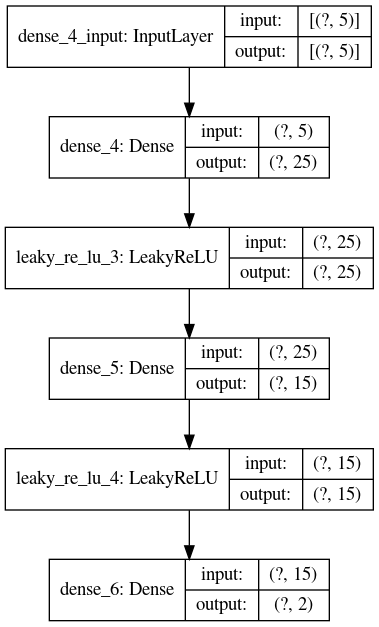

In [4]:
latent_dim = 5
generator_model = define_generator(latent_dim)
generator_model.summary()
plot_model(generator_model, to_file = 'generator_model.png', show_shapes = True, show_layer_names = True)

The function generates_latent_points generates n points in the latent space. The generate_fake_samples function uses the generator model to generate 'fake' samples.

In [5]:
def generate_latent_points(latent_dim, n):
    '''generate points in latent space as input for the generator'''
    x_input = np.random.rand(latent_dim*n) #generate points in latent space
    x_input = x_input.reshape(n,latent_dim)  #reshape
    return x_input

def generate_fake_samples(generator, latent_dim, n):
    x_input = generate_latent_points(latent_dim, n) #genarate points in latent space
    x = generator.predict(x_input) #predict outputs
    y = np.zeros((n, 1))
    return x, y

As of now, the fake samples produced by the generator is garbage because we haven't trained it yet. It is supposed to closely follow our function after training.

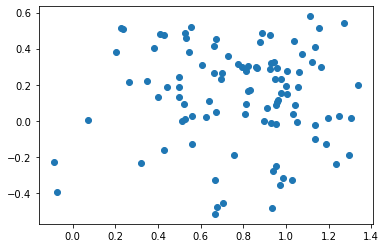

In [6]:
X, _ = generate_fake_samples(generator_model, latent_dim, 100)
plt.scatter(X[:,0], X[:,1])
plt.show()

The function below combines the generator and discriminator models. The layers of the discriminator model are made non-trainable( because we do not want to update it's weights during the training of the generator). Here, the discriminator's only job is to classify real and fake samples.

In [7]:
def define_gan(generator, discriminator):
    '''define the combined generator and discriminator model'''
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy')
    return model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 2)                 572       
_________________________________________________________________
sequential (Sequential)      (None, 1)                 551       
Total params: 1,123
Trainable params: 572
Non-trainable params: 551
_________________________________________________________________


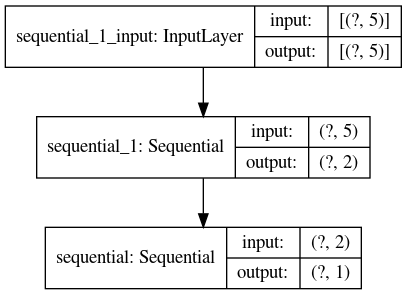

In [8]:
gan_model = define_gan(generator_model, discriminator_model)
gan_model.summary()
plot_model(gan_model, to_file = 'gan_model.png', show_layer_names = True, show_shapes = True)

We want the discriminator model to believe that the samples generated by the generator are real, so we label them as '1'(real). In the ideal case, the discriminator is fooled about half of the times into believing that the samples generated by the generator are real.

The train_gan function simultaneously trains the discriminator and the GAN.

In [9]:
def train_gan(g_model,d_model,gan_model,latent_dim, num_epochs = 10000,num_eval = 2000, batch_size = 128):
    ''' function to train gan model'''
    half_batch = int(batch_size/2)
  #run epochs
    for i in range(num_epochs):
        X_real, y_real = generate_real_samples(half_batch) #generate real examples
        d_model.train_on_batch(X_real, y_real)               # train on real data
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch) #generate fake samples
        d_model.train_on_batch(X_fake, y_fake)                #train on fake data
        #prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, batch_size)
        y_gan = np.ones((batch_size, 1))    #generate fake labels for gan
        gan_model.train_on_batch(x_gan, y_gan)
        if (i+1) % num_eval == 0:
            summarize_performance(i + 1, g_model, d_model, latent_dim)

The function defined below is called every two thousand epochs to summarize the performance of the training.

In [10]:
def summarize_performance(epoch, generator, discriminator, latent_dim, n = 100):
    '''evaluate the discriminator and plot real and fake samples'''
    x_real, y_real = generate_real_samples(n)      #generate real samples
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose = 1)
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose = 1)
    print('Epoch: ' + str(epoch) + ' Real Acc.: ' + str(acc_real) + ' Fake Acc.: '+ str(acc_fake))
    plt.scatter(x_real[:,0], x_real[:,1], color = 'red')
    plt.scatter(x_fake[:,0], x_fake[:,1], color = 'blue')
    plt.show()

4/4 [==============================] - 0s 1ms/step - loss: 0.7867 - accuracy: 0.0000e+00
Epoch: 2000 Real Acc.: 1.0 Fake Acc.: 0.0


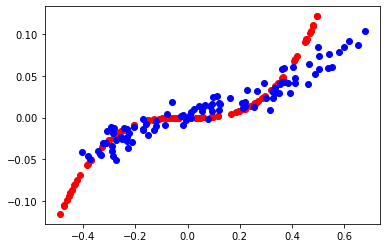

4/4 [==============================] - 0s 1ms/step - loss: 0.6753 - accuracy: 0.6800
Epoch: 4000 Real Acc.: 0.4399999976158142 Fake Acc.: 0.6800000071525574


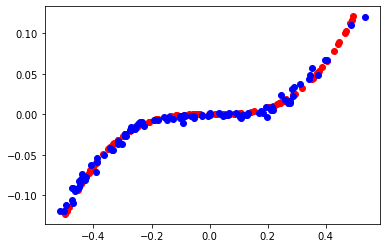

4/4 [==============================] - 0s 1ms/step - loss: 0.6849 - accuracy: 0.7000
Epoch: 6000 Real Acc.: 0.3100000023841858 Fake Acc.: 0.699999988079071


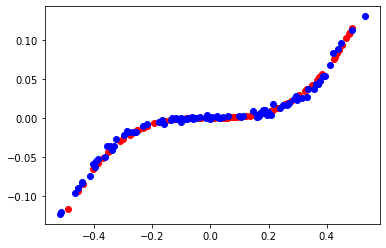

4/4 [==============================] - 0s 1ms/step - loss: 0.6900 - accuracy: 0.5700
Epoch: 8000 Real Acc.: 0.6399999856948853 Fake Acc.: 0.5699999928474426


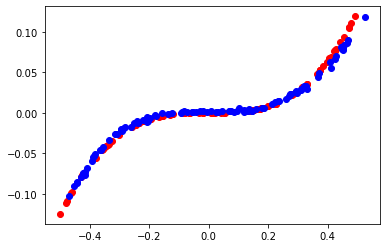

4/4 [==============================] - 0s 1ms/step - loss: 0.6818 - accuracy: 0.8300
Epoch: 10000 Real Acc.: 0.4399999976158142 Fake Acc.: 0.8299999833106995


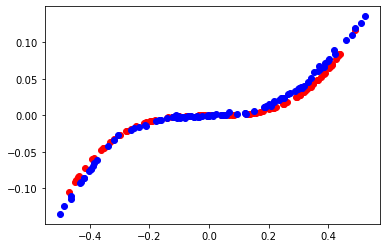

In [11]:
train_gan(generator_model, discriminator_model, gan_model, latent_dim)

References:
1. <a href = 'https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-1-dimensional-function-from-scratch-in-keras/' >This </a> blog article.
2. The GAN paper by Ian Goodfellow: https://arxiv.org/pdf/1406.2661.pdf

Improvements and further insights possible:
1. Try deeper layers in discriminator and generator models.
2. Try experimenting with different activation functions and learning rates
3. Try out more functions!